### This notebook contains all the plots from the paper
It doesn't perform any training

In [1]:
import sys
sys.path.insert(0, '../Tools')

In [2]:
import data_prep
import model_tools
import visualizing_tools
import evaluation_tools

/home/adhamija/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import numpy as np
import pandas as pd
import cPickle
import csv
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import scipy
import multiprocessing
from multiprocessing import pool,Pool
from functools import partial

Set the GPU to Use

In [4]:
GPU_NO="0"
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = GPU_NO
set_session(tf.Session(config=config))

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten,Input,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras import backend as K

##### Loading all Datasets

In [6]:
mnist=data_prep.mnist_data_prep()
letters=data_prep.letters_prep()
cifar=data_prep.cifar_prep()
hindi=data_prep.hindi_letters()
not_mnist=data_prep.NOT_MNIST()

##### OpenMax Processing for Comparision

In [7]:
def write_openmax_data(Ground_truth_labels,intermediate_output,test=True):
    print np.arange(Ground_truth_labels.shape[0]).shape,Ground_truth_labels.shape,intermediate_output[2].shape
    stacked_file_data=np.concatenate((
                                        np.arange(Ground_truth_labels.shape[0])[:,np.newaxis].astype(np.int32),  # SAMPLE_IDENTIFIER
                                        Ground_truth_labels[:,np.newaxis].astype(np.int32),    # GT_CLASS_ID
                                        intermediate_output[2]
                                        ),axis=1)
    df=pd.DataFrame(stacked_file_data)
    if test:
        df.to_csv('Test_MNIST_openMax_pred.txt', sep=' ', index=False, header=False)
    else:
        df.to_csv('Train_MNIST_openMax_pred.txt', sep=' ', index=False, header=False)
        
    stacked_file_data=np.concatenate((
                                        np.arange(Ground_truth_labels.shape[0])[:,np.newaxis].astype(np.int32),  # SAMPLE_IDENTIFIER
                                        intermediate_output[1]
                                        ),axis=1)
    df=pd.DataFrame(stacked_file_data)    
    if test:
        df.to_csv('Test_MNIST_openMax_deep_features.txt', sep=' ', index=False, header=False)    
    else:
        df.to_csv('Train_MNIST_openMax_deep_features.txt', sep=' ', index=False, header=False)    


In [8]:
def analyze(model,pos_x=mnist.X_test,pos_y=mnist.labels_test,neg=not_mnist.images,file_name='Vanilla_{}.{}',neg_labels='Not_MNIST'):
    mnist_intermediate_output=model_tools.extract_features(model,pos_x,layer_name=['fc','softmax','pred']) #['softmax','fc','pred']
    
    if neg is not None:
        neg_intermediate_output=model_tools.extract_features(model,neg,layer_name=['fc','softmax','pred'])
        write_openmax_data(np.concatenate((pos_y,np.ones(neg_intermediate_output[0].shape[0])*-1)),
                                 [np.concatenate((mnist_intermediate_output[1],neg_intermediate_output[1]),axis=0),
                                  np.concatenate((mnist_intermediate_output[0],neg_intermediate_output[0]),axis=0),
                                  np.concatenate((mnist_intermediate_output[1],neg_intermediate_output[1]),axis=0),
                                 ]
                          )
    else:
        write_openmax_data(pos_y,[mnist_intermediate_output[1],mnist_intermediate_output[0],mnist_intermediate_output[2]],test=False)

    pred_weights=model.get_layer('pred').get_weights()[0]
    print pred_weights.shape
    
    
    visualizing_tools.plotter_2D(
                                    mnist_intermediate_output[0],
                                    pos_y,
                                    neg_intermediate_output[0],
                                    final=True,
                                    file_name='LeNet++/Final_Plots/'+file_name,
                                    pos_labels='MNIST Digits',
                                    neg_labels=neg_labels,
                                    pred_weights=pred_weights
                #                    title="Histogram - Network trained with only MNIST digits"
                                )
    
    visualizing_tools.plot_softmax_histogram(
                                                mnist_intermediate_output[1],
                                                neg_intermediate_output[1],
                                                file_name='LeNet++/Final_Plots/'+file_name,
                                                pos_labels='MNIST Digits',
                                                neg_labels=neg_labels
                            #                    title="Histogram - Network trained with only MNIST digits"
                                            )
    gt_y = np.concatenate((mnist.labels_test,np.ones(neg_intermediate_output[1].shape[0])*10),axis=0)
    pred_y = np.concatenate((mnist_intermediate_output[1],neg_intermediate_output[1]),axis=0)
    evaluation_tools.write_file_for_DIR(gt_y,pred_y,file_name=('LeNet++/DIRs/'+file_name).format(neg_labels,'txt'),
                                        feature_vector=np.concatenate((mnist_intermediate_output[0],neg_intermediate_output[0])),
                                        num_of_known_classes=10)

### Using Not MNIST

In [9]:
random_model_no='0'
dataset_type='Not_MNIST'

##### Network Trained with only MNIST Samples

(28724,) (28724,) (28724, 10)
(2, 10)


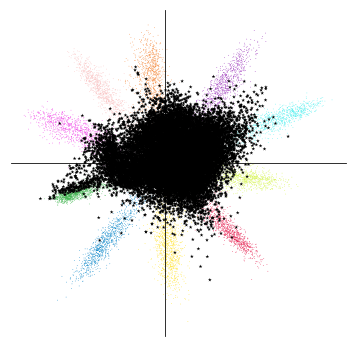

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
61.33909 18.493767 23.552114 13.007516


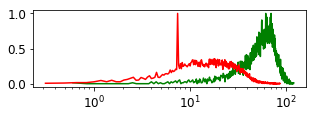

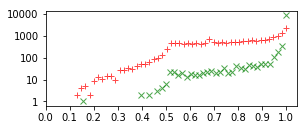

file_name LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Vanilla_0_Not_MNIST.txt


In [10]:
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}')

##### Network Trained with Letters as Background Class

In [ ]:
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}')

##### Entropic OpenSet

Raw MNIST trained with Letters Samples as negatives (CrossEntropy Label for negatives = 0.1)

(28724,) (28724,) (28724, 10)
(2, 10)


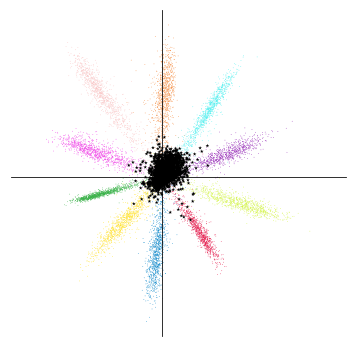

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
46.828842 17.179728 1.7672931 2.70217


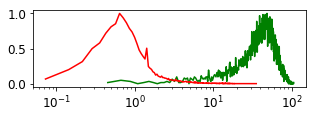

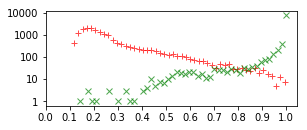

file_name LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Cross_0_Not_MNIST.txt


In [11]:
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}')

##### Training with ObjectoSphere

##### Prerequisites for Testing Objectosphere

In [15]:
def ring_loss(y_true,y_pred):
    pred=K.sqrt(K.sum(K.square(y_pred),axis=1))
    error=K.mean(K.square(
        # Loss for Knowns having magnitude greater than knownsMinimumMag
        y_true[:,0]*(K.maximum(knownsMinimumMag-pred,0.))
        # Add two losses
        +
        # Loss for unKnowns having magnitude greater than unknownsMaximumMag
        y_true[:,1]*(pred)
    ))
    return error
X_train,Y_train,sample_weights,Y_pred_with_flags=model_tools.concatenate_training_data(mnist,letters.X_train,0.1,ring_loss=True)
knownsMinimumMag = Input((1,), dtype='float32', name='knownsMinimumMag')
knownsMinimumMag_ = np.ones((X_train.shape[0]))*50

(28724,) (28724,) (28724, 10)
(2, 10)


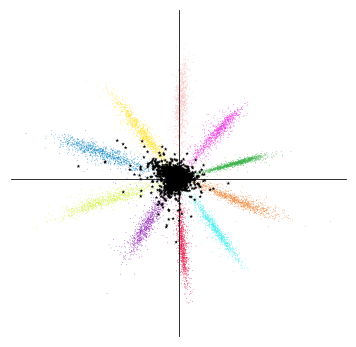

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
76.8012 28.545214 2.1859846 4.7255964


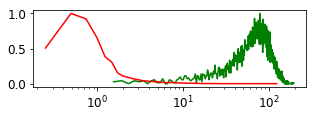

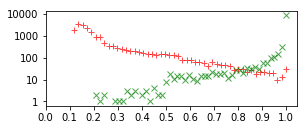

file_name LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Ring_0_Not_MNIST.txt


In [16]:
Ring_Loss_Lenet_pp = keras.models.load_model('LeNet++/Models/Ring_'+random_model_no+'.h5py', custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,file_name=dataset_type+'/Ring_'+random_model_no+'_{}.{}')

#### Testing with other Random Model Weight Initialization

(28724,) (28724,) (28724, 10)
(2, 10)


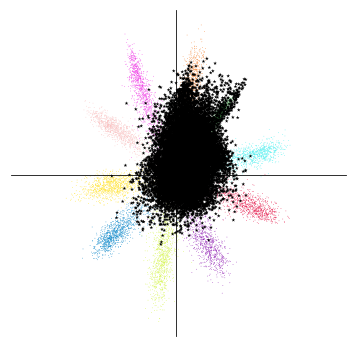

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
74.108215 21.913227 30.799421 19.118134


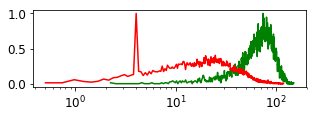

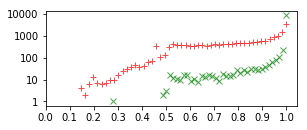

file_name LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Vanilla_1_Not_MNIST.txt
(28724,) (28724,) (28724, 11)
(2, 11)


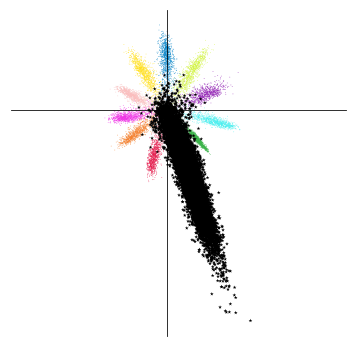

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
59.772213 18.560719 90.74068 45.50448


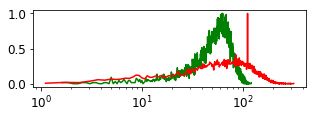

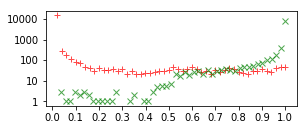

file_name LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_BG_1_Not_MNIST.txt
(28724,) (28724,) (28724, 10)
(2, 10)


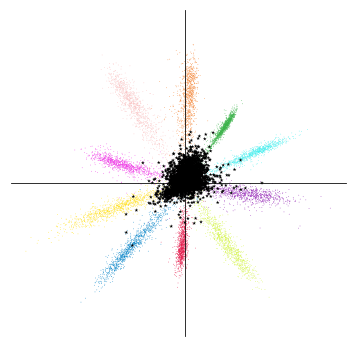

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
47.73589 16.586567 2.5503862 3.7121463


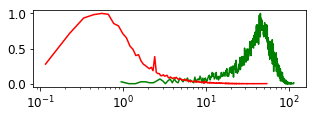

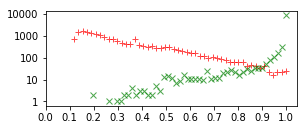

file_name LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Cross_1_Not_MNIST.txt
(28724,) (28724,) (28724, 10)
(2, 10)


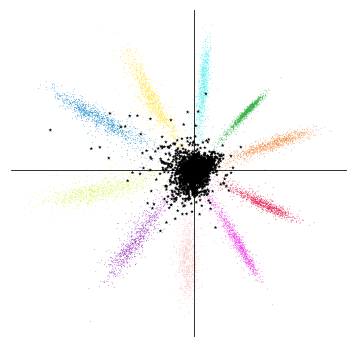

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
88.93394 29.215815 3.2138429 5.703887


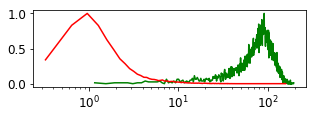

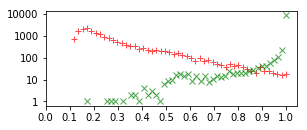

file_name LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Ring_1_Not_MNIST.txt


In [17]:
random_model_no='1'
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}')
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}')
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}')
Ring_Loss_Lenet_pp = keras.models.load_model('LeNet++/Models/Ring_'+random_model_no+'.h5py', custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,file_name=dataset_type+'/Ring_'+random_model_no+'_{}.{}')

(28724,) (28724,) (28724, 10)
(2, 10)


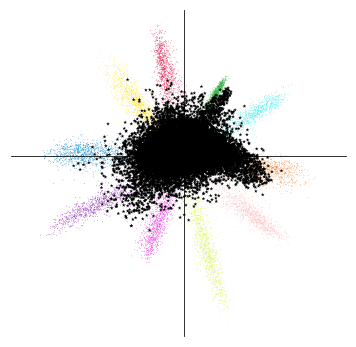

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
65.69352 21.46009 21.348488 12.9708395


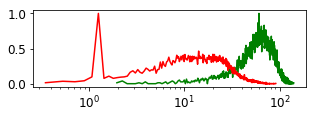

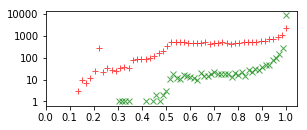

file_name LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Vanilla_2_Not_MNIST.txt
(28724,) (28724,) (28724, 11)
(2, 11)


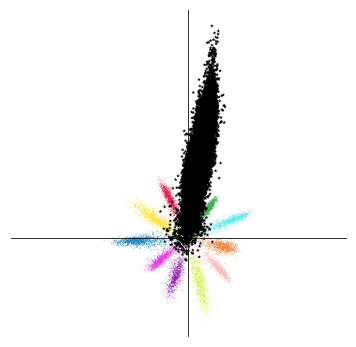

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
70.999985 22.136759 136.85884 62.519707


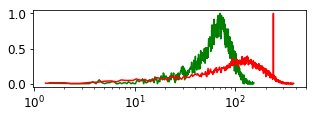

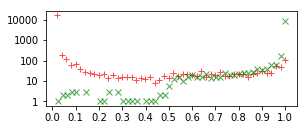

file_name LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_BG_2_Not_MNIST.txt
(28724,) (28724,) (28724, 10)
(2, 10)


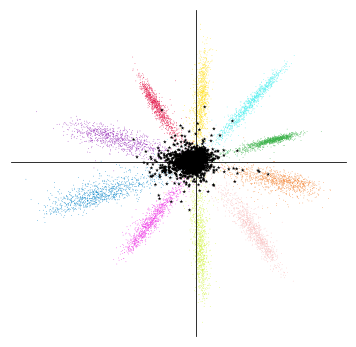

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
49.04213 17.202692 1.9868246 2.6874797


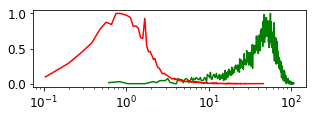

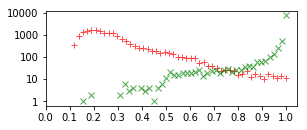

file_name LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Cross_2_Not_MNIST.txt
(28724,) (28724,) (28724, 10)
(2, 10)


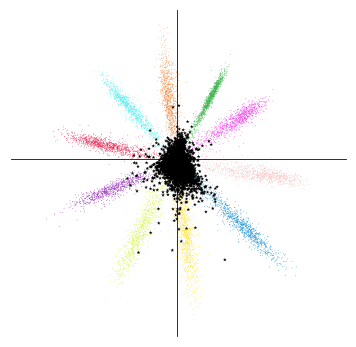

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
72.41652 26.675985 4.13426 5.978619


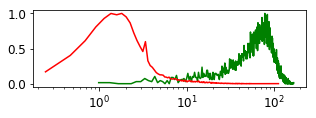

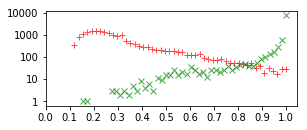

file_name LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Ring_2_Not_MNIST.txt


In [18]:
random_model_no='2'
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}')
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}')
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}')
Ring_Loss_Lenet_pp = keras.models.load_model('LeNet++/Models/Ring_'+random_model_no+'.h5py', custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,file_name=dataset_type+'/Ring_'+random_model_no+'_{}.{}')

#### Plotting DIR curves as seen in the paper

In [25]:
def evaluation_plotter(dataset_type,random_model_no='0'):
    evaluation_tools.process_files(DIR_filename='LeNet++/Final_Plots/'+dataset_type+'/DIR_Unknowns_'+random_model_no,
                                   files_to_process=[
                                                        'LeNet++/DIRs/'+dataset_type+'/Vanilla_'+random_model_no+'_'+dataset_type+'.txt',
                                                        'LeNet++/DIRs/'+dataset_type+'/BG_'+random_model_no+'_'+dataset_type+'.txt',
                                                        'LeNet++/DIRs/'+dataset_type+'/Cross_'+random_model_no+'_'+dataset_type+'.txt',
                                                        'LeNet++/DIRs/'+dataset_type+'/Ring_'+random_model_no+'_'+dataset_type+'.txt',
                                                        'LeNet++/DIRs/'+dataset_type+'/Multiplying_with_mag_Ring_'+random_model_no+'_'+dataset_type+'.txt'
                                                    ],
                                   labels=['SoftMax','Background','Entropic OpenSet Loss','ObjectSphere','Mag ObjectSphere'],
                                   out_of_plot=True
                                )

Plotting
SoftMax 0.0 & 0.0 & 0.6061 & 0.906 & 
Background 0.3885 & 0.7091 & 0.8826 & 0.967 & 
Entropic OpenSet Loss 0.6731 & 0.882 & 0.9654 & 0.98 & 
ObjectSphere 0.5179 & 0.8413 & 0.955 & 0.9785 & 
Mag ObjectSphere 0.1508 & 0.8297 & 0.9592 & 0.9786 & 
LeNet++/Final_Plots/Not_MNIST/DIR_Unknowns_0.pdf


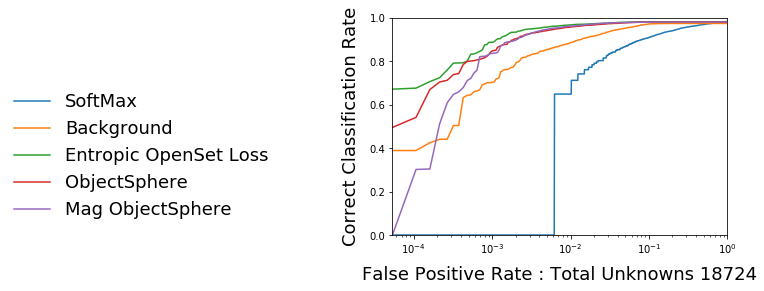

In [21]:
evaluation_plotter(dataset_type,'0')

Plotting
SoftMax 0.0 & 0.3397 & 0.4954 & 0.8288 & 
Background 0.3806 & 0.7179 & 0.9068 & 0.9624 & 
Entropic OpenSet Loss 0.4201 & 0.8578 & 0.9515 & 0.978 & 
ObjectSphere 0.512 & 0.8965 & 0.9563 & 0.9773 & 
Mag ObjectSphere 0.1184 & 0.8538 & 0.9646 & 0.9778 & 
LeNet++/Final_Plots/Not_MNIST/DIR_Unknowns_1.pdf


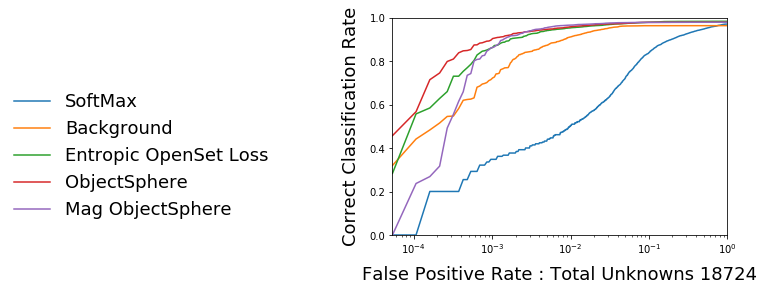

In [22]:
evaluation_plotter(dataset_type,'1')

Plotting
SoftMax 0.1278 & 0.2642 & 0.5535 & 0.8699 & 
Background 0.6598 & 0.8378 & 0.9329 & 0.9725 & 
Entropic OpenSet Loss 0.5854 & 0.8561 & 0.9545 & 0.9788 & 
ObjectSphere 0.2154 & 0.7474 & 0.9226 & 0.9713 & 
Mag ObjectSphere 0.0658 & 0.7529 & 0.9327 & 0.973 & 
LeNet++/Final_Plots/Not_MNIST/DIR_Unknowns_2.pdf


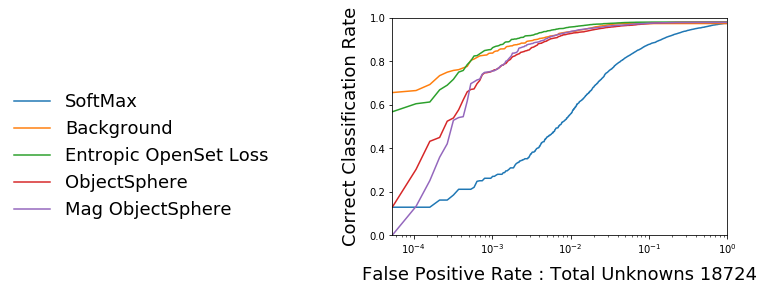

In [23]:
evaluation_plotter(dataset_type,'2')

### Comparision with CIFAR

In [27]:
dataset_type='CIFAR'
random_model_no='0'

(20000,) (20000,) (20000, 10)
(2, 10)


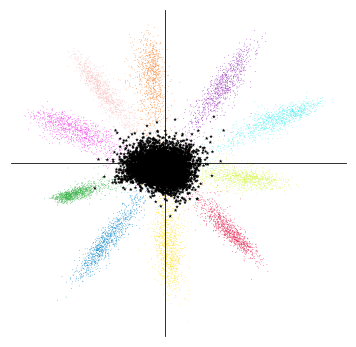

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
61.33909 18.493767 9.889335 5.709501


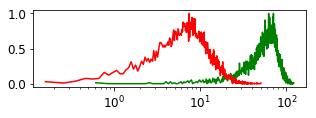

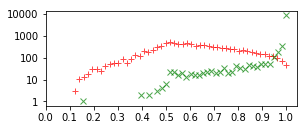

file_name LeNet++/DIRs/CIFAR/Multiplying_with_mag_Vanilla_0_CIFAR.txt


In [28]:
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,neg=cifar.images,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

(20000,) (20000,) (20000, 11)
(2, 11)


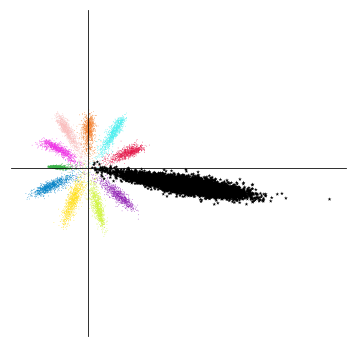

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
72.37676 21.75644 198.21863 49.845684


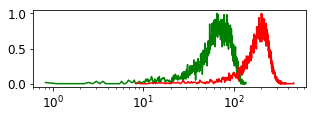

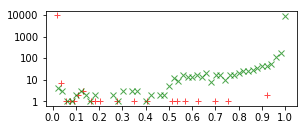

file_name LeNet++/DIRs/CIFAR/Multiplying_with_mag_BG_0_CIFAR.txt


In [29]:
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,neg=cifar.images,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

(20000,) (20000,) (20000, 10)
(2, 10)


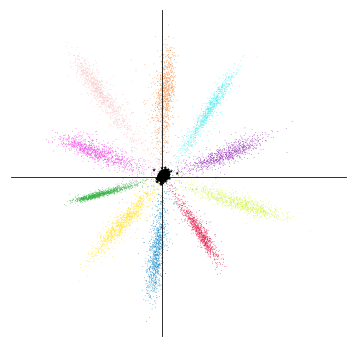

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
46.828842 17.179728 0.70805115 0.63253725


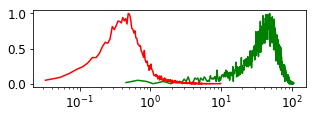

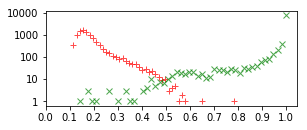

file_name LeNet++/DIRs/CIFAR/Multiplying_with_mag_Cross_0_CIFAR.txt


In [30]:
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,neg=cifar.images,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

(20000,) (20000,) (20000, 10)
(2, 10)


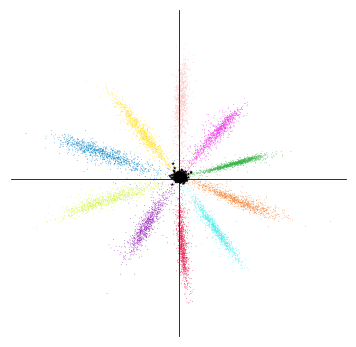

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
76.8012 28.545214 0.7589237 1.1251941


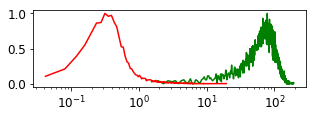

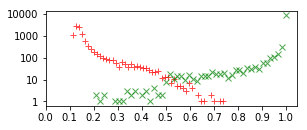

file_name LeNet++/DIRs/CIFAR/Multiplying_with_mag_Ring_0_CIFAR.txt


In [31]:
Ring_Loss_Lenet_pp = keras.models.load_model('LeNet++/Models/Ring_'+random_model_no+'.h5py', custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,neg=cifar.images,file_name=dataset_type+'/Ring_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

### Comparision On Known Unknown Letters

In [32]:
random_model_no='0'
dataset_type='Letters_Known_Unknowns'

(30800,) (30800,) (30800, 10)
(2, 10)


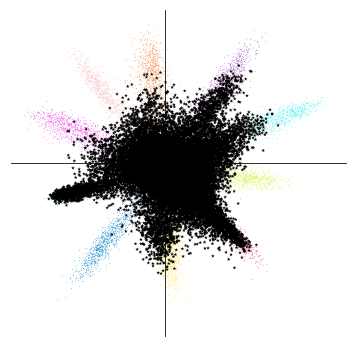

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
61.33909 18.493767 27.84317 16.909445


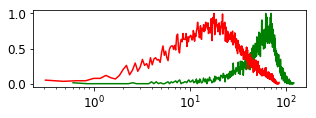

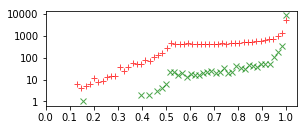

file_name LeNet++/DIRs/Letters_Known_Unknowns/Multiplying_with_mag_Vanilla_0_Letters_Known_Unknowns.txt


In [33]:
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,neg=letters.X_test,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

(30800,) (30800,) (30800, 11)
(2, 11)


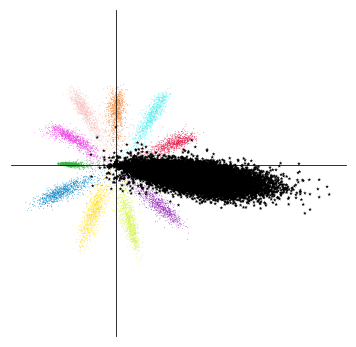

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
72.37676 21.75644 95.97207 40.63365


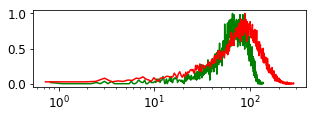

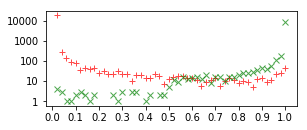

file_name LeNet++/DIRs/Letters_Known_Unknowns/Multiplying_with_mag_BG_0_Letters_Known_Unknowns.txt


In [34]:
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,neg=letters.X_test,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

(30800,) (30800,) (30800, 10)
(2, 10)


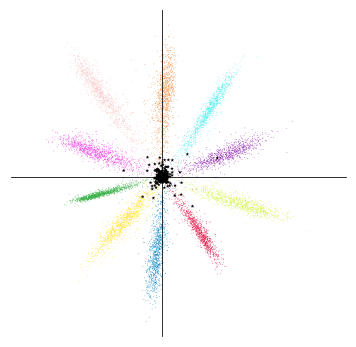

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
46.828842 17.179728 0.6355935 0.7020823


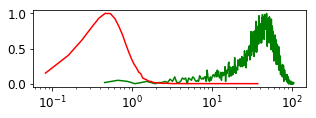

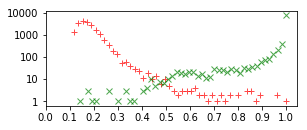

file_name LeNet++/DIRs/Letters_Known_Unknowns/Multiplying_with_mag_Cross_0_Letters_Known_Unknowns.txt


In [35]:
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,neg=letters.X_test,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

(30800,) (30800,) (30800, 10)
(2, 10)


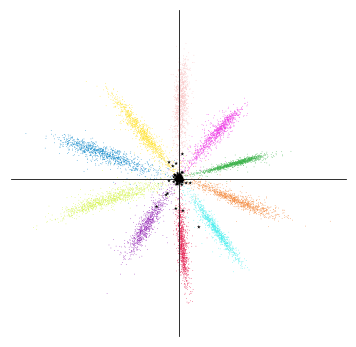

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
76.8012 28.545214 0.42051363 0.8304443


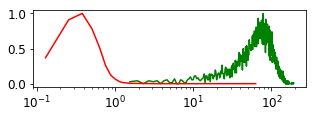

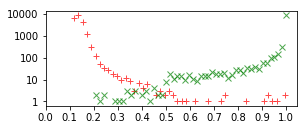

file_name LeNet++/DIRs/Letters_Known_Unknowns/Multiplying_with_mag_Ring_0_Letters_Known_Unknowns.txt


In [36]:
Ring_Loss_Lenet_pp = keras.models.load_model('LeNet++/Models/Ring_'+random_model_no+'.h5py', custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,neg=letters.X_test,file_name=dataset_type+'/Ring_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

### Comparision On Devanagari

In [37]:
random_model_no='0'
dataset_type='Devanagari'

(20032,) (20032,) (20032, 10)
(2, 10)


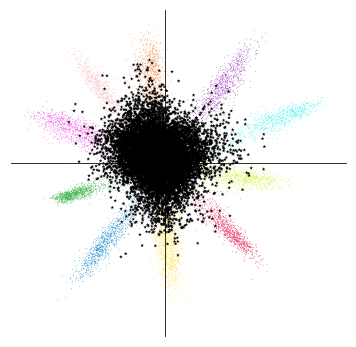

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
61.33909 18.493767 19.828491 11.455183


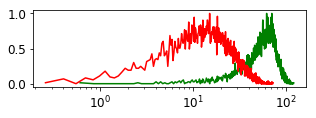

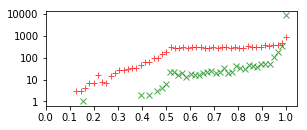

file_name LeNet++/DIRs/Devanagari/Multiplying_with_mag_Vanilla_0_Devanagari.txt


In [38]:
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,neg=hindi.images,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

(20032,) (20032,) (20032, 11)
(2, 11)


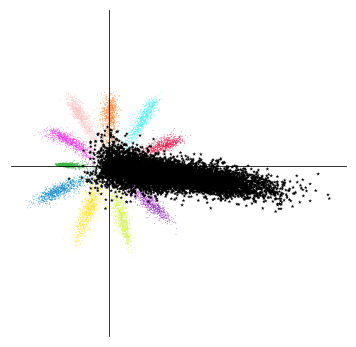

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
72.37676 21.75644 86.12366 55.31444


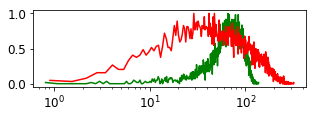

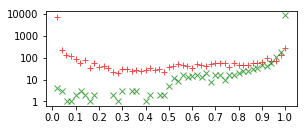

file_name LeNet++/DIRs/Devanagari/Multiplying_with_mag_BG_0_Devanagari.txt


In [39]:
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,neg=hindi.images,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

(20032,) (20032,) (20032, 10)
(2, 10)


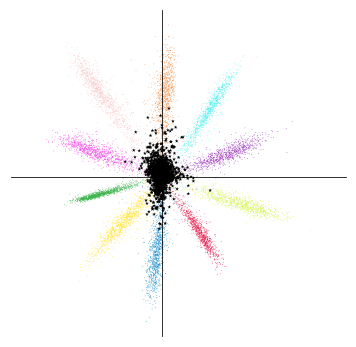

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
46.828842 17.179728 2.2153282 3.2339296


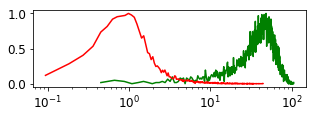

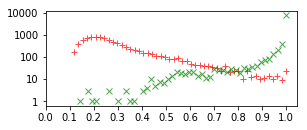

file_name LeNet++/DIRs/Devanagari/Multiplying_with_mag_Cross_0_Devanagari.txt


In [40]:
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,neg=hindi.images,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

(20032,) (20032,) (20032, 10)
(2, 10)


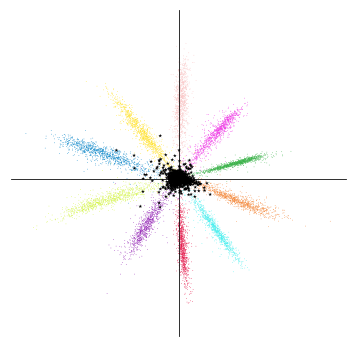

Mag np.mean(pos_mag),np.std(pos_mag),np.mean(neg_mag),np.std(neg_mag)
76.8012 28.545214 1.6111467 3.3319032


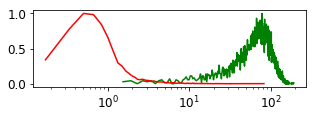

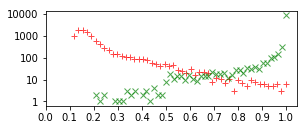

file_name LeNet++/DIRs/Devanagari/Multiplying_with_mag_Ring_0_Devanagari.txt


In [41]:
Ring_Loss_Lenet_pp = keras.models.load_model('LeNet++/Models/Ring_'+random_model_no+'.h5py', custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,neg=hindi.images,file_name=dataset_type+'/Ring_'+random_model_no+'_{}.{}',neg_labels=dataset_type)